In [1]:
import pandas as pd
import numpy as np
import torch

/Users/alexkorman/miniconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [360]:
train = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_values.csv")

In [361]:
train.columns, train_labels.columns

(Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
        'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
        'land_surface_condition', 'foundation_type', 'roof_type',
        'ground_floor_type', 'other_floor_type', 'position',
        'plan_configuration', 'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
        'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
        'has_superstructure_rc_engineered', 'has_superstructure_other',
        'legal_ownership_status', 'count_families', 'has_secondary_use',
        'has_secondary_use_agriculture', 'has_secondary_use_hotel',
        'has_secondary_use_rental', 'has_secondary_use_institution',
        'has_secondary_use_school', 'has_

In [362]:
train.shape, test.shape

((260601, 39), (86868, 39))

In [363]:
# one hot encode column

def one_hot(df, col):
    unique = df[col].unique()
    keys = {}
    for i, k in enumerate(unique):
        code = np.zeros(len(unique))
        code[i] = 1
        keys[k] = code

    hot_col = []
    for i in range(len(df[col])):
        k = df[col].loc[i]
        hot_col.append(keys[k])

    return np.array(hot_col)


one_hot(train, "foundation_type")

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [364]:
# apply encoding to multiple columns

def apply_one_hot(df, columns):
    for col in columns:
       new_col = one_hot(df, col)
       for i in range(new_col.shape[1]): # make each encoding its own column
           df[col+"_"+str(i)] = new_col[:,i]
       df.drop([col], inplace = True, axis=1)
    return df

In [365]:
# list of all columns to be encoded
cols_to_use = [
        'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
        'land_surface_condition', 'foundation_type', 'roof_type',
        'ground_floor_type', # 'other_floor_type', 'position',
       ]
cols_to_update = ["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type"]#, #"other_floor_type", "position"]

train = train[cols_to_use]
test = test[cols_to_use]

In [366]:
train_hot = apply_one_hot(train, cols_to_update)
test_hot =  apply_one_hot(test, cols_to_update)

In [367]:
train_hot.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_0,land_surface_condition_1,land_surface_condition_2,foundation_type_0,foundation_type_1,foundation_type_2,foundation_type_3,foundation_type_4,roof_type_0,roof_type_1,roof_type_2,ground_floor_type_0,ground_floor_type_1,ground_floor_type_2,ground_floor_type_3,ground_floor_type_4
0,2,30,6,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,10,8,7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,10,5,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,10,6,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,30,8,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [368]:
# sanity check all categories are present in train and test set
len(train_hot.columns) == len(test_hot.columns)

True

In [369]:
x = train_hot.values
x_test = test_hot.values
labels = train_labels.damage_grade.values

In [370]:
x.shape, labels.shape

((260601, 20), (260601,))

In [371]:
scaler = StandardScaler()
scaler.fit(x[:,:4])
x_x = scaler.transform(x[:,:4])
x[:,:4] = x_x

In [372]:
import copy


train_hot_w_labels = copy.deepcopy(train_hot)
train_hot_w_labels["labels"] = labels
corr = train_hot.corr()

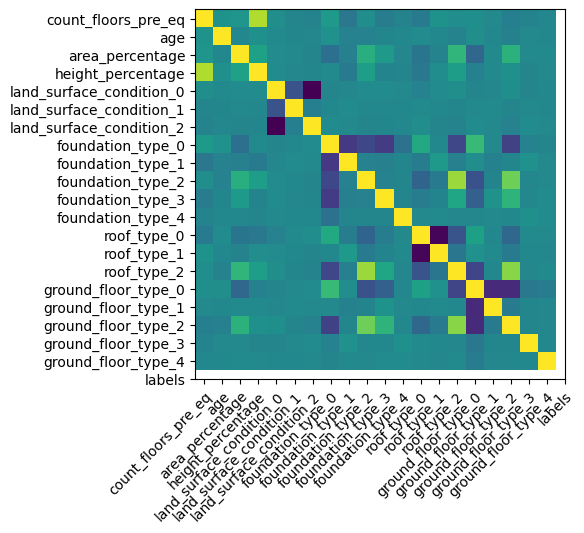

In [374]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(corr)
ax.set_xticks(np.arange(len(train_hot_w_labels.columns.values)), labels=train_hot_w_labels.columns.values)
ax.set_yticks(np.arange(len(train_hot_w_labels.columns.values)), labels=train_hot_w_labels.columns.values)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# for i in range(len(train_hot_w_labels.columns.values)):
#     for j in range(len(train_hot_w_labels.columns.values)):
#         text = ax.text(j, i, corr[i, j],
#                        ha="center", va="center", color="w")

# plt.imshow(corr, cmap='hot', interpolation='nearest')
fig.figsize = (100,100)
# fig.tight_layout()
plt.show()

In [375]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV


In [376]:
pipe = make_pipeline( RandomForestClassifier(random_state=42))
pipe

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [377]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [378]:
gs.fit(x, train_labels.damage_grade.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [379]:
gs.best_params_


{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [380]:

from sklearn.metrics import f1_score

in_sample_preds = gs.predict(x)
f1_score(train_labels.damage_grade.values, in_sample_preds, average='micro')

0.6223652249991366

In [381]:
predictions = gs.predict(x_test)

In [165]:
from sklearn.svm import SVC

pipe = make_pipeline(SVC(random_state=42))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [166]:
pipe.fit(x, train_labels.damage_grade.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [167]:
from sklearn.metrics import f1_score

in_sample_preds = pipe.predict(x)
f1_score(train_labels.damage_grade.values, in_sample_preds, average='micro')

0.6083514644993687

In [382]:
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class DS(Dataset):
     def __init__(self, x,y, classes=3):
         super(Dataset, self).__init__()
         self.x = torch.tensor(x).float()
         self.classes = classes
         self.y = (torch.tensor(y) - torch.ones(size=y.shape)).long()
        #  self.y = torch.zeros(size=(len(self.x), classes)).long()
        #  labels = (torch.tensor(y) - torch.ones(size=y.shape)).long()
        #  for i in range(len(self.y)):
        #      self.y[i][labels[i]] = 1
        
     def __len__(self):
         return len(x)
        
     def __getitem__(self, index):
        assert self.__len__() > index
        return self.x[index], self.y[index]

ds = DS(x, labels)
train_size = int(0.9 * len(ds))
val_size = len(ds) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(ds, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [383]:
import torch.nn as nn

class DNN(nn.Module):
  def __init__(self, input_size, classes):
    super().__init__()
    self.input_size = input_size
    self.classes = classes
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
        nn.Linear(self.input_size,16),
        nn.ReLU(),
        # nn.Dropout(p=0.2),
        nn.Linear(16,self.classes),
        # nn.ReLU(),
        # nn.Dropout(p=0.2),
        # nn.Linear(32, self.classes),
        nn.Sigmoid()
    )

    ################################ END TODO #######################################
  
  def forward(self, x):
    return self.net(x)
  
  def loss(self, criterion, output, target):
    return criterion(output, target)

model = DNN(x.shape[1], 3)

In [384]:
ds.x[0]
x[0]

array([-0.17827372,  0.0471003 , -0.45946001, -0.22641883,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [386]:
from torch import optim, nn


device = torch.device("cpu")
# Prob1-2
epochs = 16
learning_rate = 1e-5
# set model in train mode 
model = model.train()   
# build optimizer and loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#################################### END TODO #######################################

train_it = 0
rec_loss = 0
batch_size = 64
in_size = out_size = 224
for ep in range(epochs):
  print("Run Epoch {}".format(ep))

  for inputs, target in train_dataloader: # loads a batch of data    
    optimizer.zero_grad()

    # inputs = torch.tensor(inputs, requires_grad=True, dtype=torch.float)
    # target = target.view(-1,1)


    outputs = model(inputs)

    loss = model.loss(criterion, outputs, target)
    
    loss.backward()

    optimizer.step()

    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, loss))
    train_it += 1
  # #################################### END TODO #####################################

print("Done!")


Run Epoch 0
It 0: Reconstruction Loss: 0.8635484576225281
It 100: Reconstruction Loss: 0.9076242446899414
It 200: Reconstruction Loss: 0.8861074447631836
It 300: Reconstruction Loss: 0.9113754630088806
It 400: Reconstruction Loss: 0.8945163488388062
It 500: Reconstruction Loss: 0.9342072606086731
It 600: Reconstruction Loss: 0.8682119846343994
It 700: Reconstruction Loss: 0.9011333584785461
It 800: Reconstruction Loss: 0.8927258849143982
It 900: Reconstruction Loss: 0.9319196939468384
It 1000: Reconstruction Loss: 0.9696670770645142
It 1100: Reconstruction Loss: 0.8479469418525696
It 1200: Reconstruction Loss: 0.8475560545921326
It 1300: Reconstruction Loss: 0.8621155023574829
It 1400: Reconstruction Loss: 0.8746597170829773
It 1500: Reconstruction Loss: 0.8856027126312256
It 1600: Reconstruction Loss: 0.9381271004676819
It 1700: Reconstruction Loss: 0.8848254680633545
It 1800: Reconstruction Loss: 0.8937201499938965
It 1900: Reconstruction Loss: 0.8609103560447693
It 2000: Reconstruct

KeyboardInterrupt: 